In [7]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [8]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

# Code by hand

In [10]:
data = {'N': 100, 'y': 50} #number of trials, number of successes

In [11]:
def p_data_given_theta(theta, data):
    return theta**data['y'] * (1-theta)**(data['N']-data['y'])

from scipy.stats import beta
def p_theta(theta):
    # beta(1, 1) prior
    return beta.pdf(theta, 1, 1)

def p_data(data, possible_theta_values=np.linspace(0, 1, 1000)):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    unweighted_integral = np.sum([p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values])
    integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
    return integral

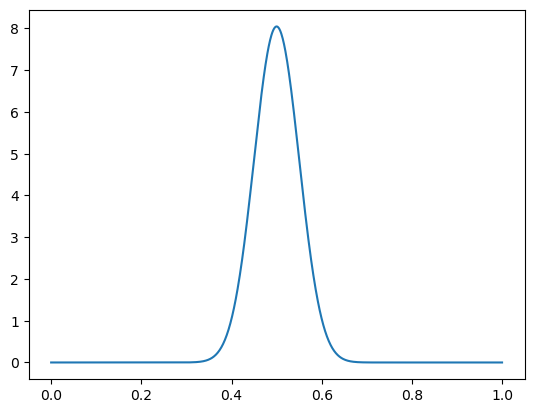

In [12]:
possible_theta_values = np.linspace(0, 1, 1000)

denominator = p_data(data, possible_theta_values)
p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                      for theta in possible_theta_values]

plt.plot(possible_theta_values, p_theta_given_data)

# Using Stan to fit a binomial model

In [13]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'binom.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Binomial model with beta(1,1,) prior
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}



In [14]:
stan_data = {'N': 100, 'y': 50} #number of trials, number of successes

In [15]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:


In [32]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)


Sampling:   0%
Sampling:  50% (1200/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!


In [33]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [34]:
summary = az.summary(fit)

In [35]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.497,0.049,0.41,0.595,0.002,0.001,657.0,995.0,1.0


<AxesSubplot: title={'center': 'theta'}>

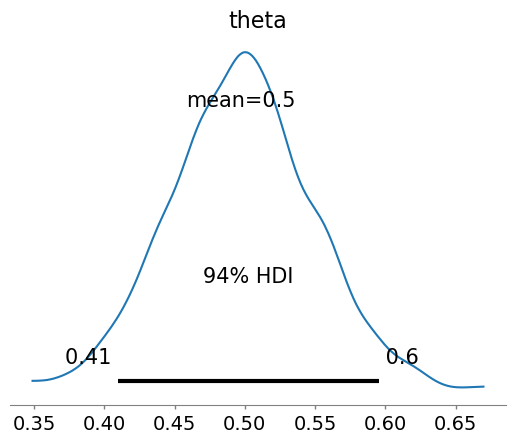

In [43]:
# Stan gives us _samples_ for theta, representing P(\theta | data)
az.plot_posterior(idata)

<AxesSubplot: xlabel='theta', ylabel='Count'>

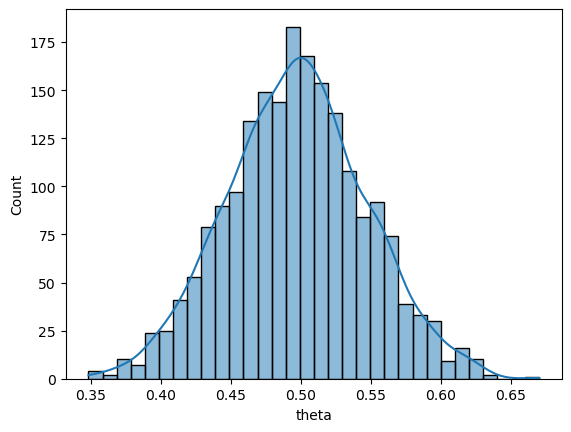

In [42]:
sns.histplot(data=az.extract(fit), x='theta', kde=True)

array([[<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

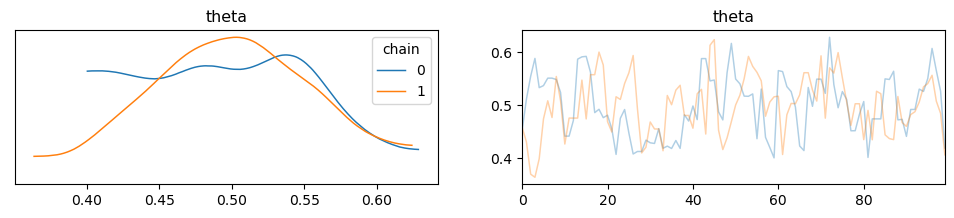

In [21]:
az.plot_trace(fit, compact=False, legend=True)